In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls "/content/drive/MyDrive/Plantvillage_Dataset"

best_finetuned_model.keras  best_model.h5     color	 segmented
best_frozen_model.keras     best_model.keras  grayscale


In [5]:
allowed_classes = [
    "Tomato___Target_Spot",
    "Pepper,_bell___Bacterial_spot",
    "Grape___Black_rot",
    "Corn_(maize)___Common_rust_",
    "Cherry_(including_sour)___Powdery_mildew"
] # 5 CLASSES

In [6]:
import os
dataset_path = "/content/drive/MyDrive/Plantvillage_Dataset/color"

selected_classes = [
    cls for cls in os.listdir(dataset_path)
    if cls in allowed_classes
]

print("Selected classes:")
for c in selected_classes:
    print(c)

print("Number of classes:", len(selected_classes))

Selected classes:
Tomato___Target_Spot
Pepper,_bell___Bacterial_spot
Grape___Black_rot
Corn_(maize)___Common_rust_
Cherry_(including_sour)___Powdery_mildew
Number of classes: 5


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

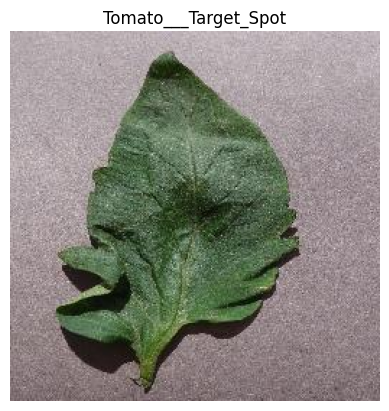

In [7]:
import random
import os
import cv2
import matplotlib.pyplot as plt


class_name = random.choice(selected_classes)
class_path = os.path.join(dataset_path, class_name)

img_name = random.choice(os.listdir(class_path))
img_path = os.path.join(class_path, img_name)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title(class_name)
plt.axis("off")

In [8]:
import tensorflow as tf
EfficientNetB3 = tf.keras.applications.EfficientNetB3
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

#resize
IMG_SIZE = 256
BATCH_SIZE = 32
SEED = 42

full_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    class_names=selected_classes,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical", # one-hot encoded
    shuffle=False,
    seed=SEED
)

full_ds = full_ds.prefetch(tf.data.AUTOTUNE)

Found 5825 files belonging to 5 classes.


In [9]:
#CHECK FOR NORMALIZATION AND RESIZING
for images, labels in full_ds.take(1):
    print("Min:", tf.reduce_min(images).numpy())
    print("Max:", tf.reduce_max(images).numpy())
    print("Shape:", images.shape)

Min: 0.0
Max: 255.0
Shape: (32, 256, 256, 3)


In [10]:
dataset_size = tf.data.experimental.cardinality(full_ds).numpy()

full_ds = full_ds.shuffle(
    buffer_size=dataset_size,
    seed=SEED,
    reshuffle_each_iteration=False
)

In [11]:
import glob
import numpy as np
import os

image_paths = []
image_labels = []

for idx, class_name in enumerate(selected_classes):
    class_dir = os.path.join(dataset_path, class_name)

    files = (
        glob.glob(os.path.join(class_dir, "*.jpg")) +
        glob.glob(os.path.join(class_dir, "*.JPG")) +
        glob.glob(os.path.join(class_dir, "*.png")) +
        glob.glob(os.path.join(class_dir, "*.PNG"))
    )

    print(class_name, "→", len(files), "images")

    image_paths.extend(files)
    image_labels.extend([idx] * len(files))

image_paths = np.array(image_paths)
image_labels = np.array(image_labels)

print("Total images:", len(image_paths))


Tomato___Target_Spot → 1404 images
Pepper,_bell___Bacterial_spot → 997 images
Grape___Black_rot → 1180 images
Corn_(maize)___Common_rust_ → 1192 images
Cherry_(including_sour)___Powdery_mildew → 1052 images
Total images: 5825


In [12]:
from collections import Counter
print("Class counts:", Counter(image_labels))
print("Total images:", len(image_paths))


Class counts: Counter({np.int64(0): 1404, np.int64(3): 1192, np.int64(2): 1180, np.int64(4): 1052, np.int64(1): 997})
Total images: 5825


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    image_paths,
    image_labels,
    test_size=0.3,
    stratify=image_labels,
    random_state=SEED
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=SEED
)

In [14]:
NUM_CLASSES = len(selected_classes)

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img, tf.one_hot(label, NUM_CLASSES)


train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = (
    train_ds
    .shuffle(buffer_size=1000, reshuffle_each_iteration=True)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [16]:
print("Total batches in full_ds :", tf.data.experimental.cardinality(full_ds).numpy())
print("Train batches           :", tf.data.experimental.cardinality(train_ds).numpy())
print("Validation batches      :", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches            :", tf.data.experimental.cardinality(test_ds).numpy())

Total batches in full_ds : 183
Train batches           : 128
Validation batches      : 874
Test batches            : 874


In [17]:
#DYNAMIC AUGMENTATION (TRAIN ONLY)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
])

def augment(x, y):
    x = data_augmentation(x, training=True)
    return x, y

train_ds = train_ds.map(
    augment,
    num_parallel_calls=tf.data.AUTOTUNE
)

In [18]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [19]:
from collections import Counter
import tensorflow as tf

def get_class_counts(ds, name):
    labels = []
    for _, y in ds:
        batch_labels = tf.argmax(y, axis=1).numpy()
        labels.extend(batch_labels.tolist())

    print(f"{name} class counts:", dict(Counter(labels)))

get_class_counts(train_ds, "TRAIN")
get_class_counts(val_ds, "VAL")
get_class_counts(test_ds, "TEST")


TRAIN class counts: {3: 834, 0: 983, 1: 698, 2: 826, 4: 736}
VAL class counts: {4: 158, 3: 179, 2: 177, 1: 150, 0: 210}
TEST class counts: {1: 149, 4: 158, 0: 211, 3: 179, 2: 177}


In [20]:
#CLASS WEIGHTS
import numpy as np

labels = []

for _, y in train_ds:
    batch_labels = tf.argmax(y, axis=1).numpy()
    labels.extend(batch_labels.tolist())

labels = np.array(labels)

In [21]:
from collections import Counter

class_counts = Counter(labels)
clean_class_counts = {int(k): int(v) for k, v in class_counts.items()}
print("Class counts:", clean_class_counts)

Class counts: {4: 736, 2: 826, 3: 834, 1: 698, 0: 983}


In [22]:
class_index_to_name = {i: name for i, name in enumerate(selected_classes)}
print("Class distribution in TRAIN:")
for class_idx, count in clean_class_counts.items():
    class_name = class_index_to_name[class_idx]
    print(f"{class_idx} ({class_name}) → {count} samples")

Class distribution in TRAIN:
4 (Cherry_(including_sour)___Powdery_mildew) → 736 samples
2 (Grape___Black_rot) → 826 samples
3 (Corn_(maize)___Common_rust_) → 834 samples
1 (Pepper,_bell___Bacterial_spot) → 698 samples
0 (Tomato___Target_Spot) → 983 samples


In [23]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

num_classes = len(class_counts)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_classes),
    y=labels
)

class_weight_dict = {int(i): float(w) for i, w in enumerate(class_weights)}
print("Class weights:", class_weight_dict)

Class weights: {0: 0.8295015259409969, 1: 1.1681948424068769, 2: 0.9871670702179177, 3: 0.9776978417266187, 4: 1.1078804347826088}


In [24]:
#Build EfficientNetB3
import tensorflow as tf

NUM_CLASSES = len(selected_classes)

base_model = tf.keras.applications.EfficientNetB3(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
#Freeze
base_model.trainable = False

In [26]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = tf.keras.applications.efficientnet.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

In [27]:
import tensorflow as tf

def categorical_focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma)

        loss = weight * cross_entropy
        return tf.reduce_sum(loss, axis=1)
    return loss

In [28]:
focal_loss = categorical_focal_loss(alpha=0.25, gamma=2.0)

In [29]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss= focal_loss,
    metrics=[
        "accuracy",
        tf.keras.metrics.TopKCategoricalAccuracy(k=2, name="top2_acc")
    ]
)

In [30]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/Plantvillage_Dataset/best_frozen_model.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

In [31]:
earlystop_cb =tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [32]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 8, 8, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,184,436 (42.67 MB)

 Trainable params: 397,829 (1.52 MB)

 Non-trainable params: 10,786,607 (41.15 MB)

In [33]:
#Train the Model
EPOCHS = 15

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight_dict,
    callbacks=[checkpoint_cb,earlystop_cb]
)

Epoch 1/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6128 - loss: 0.2086 - top2_acc: 0.7778
Epoch 1: val_loss improved from inf to 0.02820, saving model to /content/drive/MyDrive/Plantvillage_Dataset/best_frozen_model.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 1146s 9s/step - accuracy: 0.6140 - loss: 0.2079 - top2_acc: 0.7786 - val_accuracy: 0.9314 - val_loss: 0.0282 - val_top2_acc: 0.9828
Epoch 2/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9086 - loss: 0.0311 - top2_acc: 0.9752
Epoch 2: val_loss improved from 0.02820 to 0.01012, saving model to /content/drive/MyDrive/Plantvillage_Dataset/best_frozen_model.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 1108s 9s/step - accuracy: 0.9087 - loss: 0.0310 - top2_acc: 0.9753 - val_accuracy: 0.9657 - val_loss: 0.0101 - val_top2_acc: 0.9908
Epoch 3/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9446 - loss: 0.0186 - top2_acc: 0.9895
Epoch 3: val_loss improved from 0.01012 to 0.00495, saving model to /content/drive/MyDrive/Plantvi

In [34]:
import numpy as np

best_epoch = np.argmin(history.history["val_loss"])

train_acc = history.history["accuracy"][best_epoch]
val_acc   = history.history["val_accuracy"][best_epoch]

test_loss, test_acc, test_top2 = model.evaluate(test_ds, verbose=1)

print("\nFINAL MODEL PERFORMANCE")
print(f"Best epoch        : {best_epoch + 1}")
print(f"Train accuracy    : {train_acc:.4f}")
print(f"Validation accuracy: {val_acc:.4f}")
print(f"Test accuracy     : {test_acc:.4f}")
print(f"Test top-2 acc    : {test_top2:.4f}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 182s 6s/step - accuracy: 0.9922 - loss: 0.0023 - top2_acc: 1.0000

FINAL MODEL PERFORMANCE
Best epoch        : 15
Train accuracy    : 0.9868
Validation accuracy: 0.9954
Test accuracy     : 0.9931
Test top-2 acc    : 1.0000


In [35]:
#checking loading
model = tf.keras.models.load_model(
   "/content/drive/MyDrive/Plantvillage_Dataset/best_frozen_model.keras",
    custom_objects={"loss": focal_loss}
)

model.evaluate(test_ds, verbose=1)

28/28 ━━━━━━━━━━━━━━━━━━━━ 202s 7s/step - accuracy: 0.9922 - loss: 0.0023 - top2_acc: 1.0000


[0.0020118693355470896, 0.9931350350379944, 1.0]

In [36]:
# Prepare Test Paths & Labels
test_paths  = X_test
test_labels = y_test

print("Number of test samples:", len(test_paths))

Number of test samples: 874


In [37]:
 # Random Test Image Evaluation
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

# Pick a random test image
idx = random.randint(0, len(test_paths) - 1)

img_path   = test_paths[idx]
true_label = test_labels[idx]

print("Test image path :", img_path)
print("True label index:", true_label)
print("True label name :", selected_classes[true_label])


Test image path : /content/drive/MyDrive/Plantvillage_Dataset/color/Grape___Black_rot/7dbf6452-5732-4074-b567-1148f17c772c___FAM_B.Rot 3403.JPG
True label index: 2
True label name : Grape___Black_rot


In [38]:
# Load & preprocess image
img = tf.io.read_file(img_path)
img = tf.image.decode_image(img, channels=3, expand_animations=False)
img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
img = tf.cast(img, tf.float32)

# IMPORTANT: match training preprocessing
img = tf.keras.applications.efficientnet.preprocess_input(img)


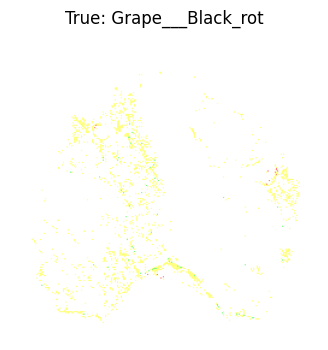

In [39]:
# Show image
plt.figure(figsize=(4,4))
plt.imshow((img + 1) / 2)  # EfficientNet normalization fix
plt.title(f"True: {selected_classes[true_label]}")
plt.axis("off")
plt.show()

In [40]:
#Predict
img_batch = tf.expand_dims(img, axis=0)
preds = model.predict(img_batch, verbose=0)

pred_class = int(np.argmax(preds))
confidence = float(np.max(preds))

print("Predicted class:", selected_classes[pred_class])
print("Confidence     :", round(confidence * 100, 2), "%")

Predicted class: Grape___Black_rot
Confidence     : 99.93 %


In [41]:
#unfreeze
base_model.trainable = True

for layer in base_model.layers[:-200]:
    layer.trainable = False

In [42]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=focal_loss,
    metrics=[
    "accuracy",
    tf.keras.metrics.TopKCategoricalAccuracy(k=2, name="top2_acc")
]
)

In [43]:
finetune_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/Plantvillage_Dataset/best_finetuned_model.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

In [44]:
#training finetuning
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=[finetune_checkpoint_cb, earlystop_cb]
)

Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9889 - loss: 0.0030 - top2_acc: 0.9996
Epoch 1: val_loss improved from inf to 0.00080, saving model to /content/drive/MyDrive/Plantvillage_Dataset/best_finetuned_model.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 1176s 9s/step - accuracy: 0.9889 - loss: 0.0030 - top2_acc: 0.9996 - val_accuracy: 0.9954 - val_loss: 8.0448e-04 - val_top2_acc: 0.9989
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9861 - loss: 0.0042 - top2_acc: 0.9979
Epoch 2: val_loss improved from 0.00080 to 0.00077, saving model to /content/drive/MyDrive/Plantvillage_Dataset/best_finetuned_model.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 1120s 9s/step - accuracy: 0.9861 - loss: 0.0042 - top2_acc: 0.9979 - val_accuracy: 0.9954 - val_loss: 7.6624e-04 - val_top2_acc: 0.9989
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9832 - loss: 0.0052 - top2_acc: 0.9993
Epoch 3: val_loss did not improve from 0.00077
128/128 ━━━━━━━━━━━━━━━━━━━━ 1092s 8s

In [45]:
# Load Best Fine-Tuned Model
import tensorflow as tf

model = tf.keras.models.load_model(
    "/content/drive/MyDrive/Plantvillage_Dataset/best_finetuned_model.keras",
    custom_objects={"loss": focal_loss}
)

In [46]:
#Test Image After Fine-Tuning
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

test_paths  = X_test
test_labels = y_test

idx = random.randint(0, len(test_paths) - 1)

img_path   = test_paths[idx]
true_label = test_labels[idx]

print("Test image path :", img_path)
print("True label index:", true_label)
print("True label name :", selected_classes[true_label])

Test image path : /content/drive/MyDrive/Plantvillage_Dataset/color/Corn_(maize)___Common_rust_/RS_Rust 1579.JPG
True label index: 3
True label name : Corn_(maize)___Common_rust_


In [47]:
img_raw = tf.io.read_file(img_path)
img_raw = tf.image.decode_image(img_raw, channels=3, expand_animations=False)
img_raw = tf.image.resize(img_raw, (IMG_SIZE, IMG_SIZE))


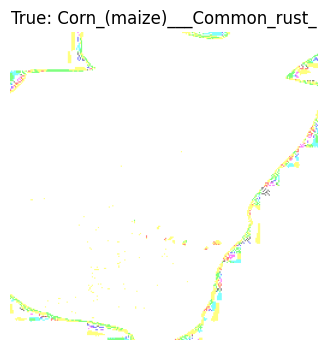

In [48]:
plt.figure(figsize=(4,4))
plt.imshow(img_raw.numpy().astype("uint8"))
plt.title(f"True: {selected_classes[true_label]}")
plt.axis("off")
plt.show()

In [ ]:
img_model = tf.cast(img_raw, tf.float32)
img_model = tf.keras.applications.efficientnet.preprocess_input(img_model)

img_batch = tf.expand_dims(img_model, axis=0)

In [49]:
preds = model.predict(img_batch, verbose=0)
pred_class = int(np.argmax(preds))
confidence = float(np.max(preds))

print("Predicted class:", selected_classes[pred_class])
print("Confidence     :", round(confidence * 100, 2), "%")

Predicted class: Corn_(maize)___Common_rust_
Confidence     : 99.99 %


In [50]:
import numpy as np

best_epoch_ft = np.argmin(history_finetune.history["val_loss"])

train_acc_ft = history_finetune.history["accuracy"][best_epoch_ft]
val_acc_ft   = history_finetune.history["val_accuracy"][best_epoch_ft]

test_loss_ft, test_acc_ft, test_top2_ft = model.evaluate(test_ds, verbose=1)

print("\nFINAL FINE-TUNED MODEL PERFORMANCE")
print(f"Best fine-tune epoch : {best_epoch_ft + 1}")
print(f"Train accuracy      : {train_acc_ft:.4f}")
print(f"Validation accuracy : {val_acc_ft:.4f}")
print(f"Test accuracy       : {test_acc_ft:.4f}")
print(f"Test top-2 accuracy : {test_top2_ft:.4f}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 215s 7s/step - accuracy: 0.9931 - loss: 0.0018 - top2_acc: 1.0000

FINAL FINE-TUNED MODEL PERFORMANCE
Best fine-tune epoch : 9
Train accuracy      : 0.9882
Validation accuracy : 0.9954
Test accuracy       : 0.9943
Test top-2 accuracy : 1.0000


Classification Report:

                                          precision    recall  f1-score   support

                    Tomato___Target_Spot     1.0000    0.9905    0.9952       211
           Pepper,_bell___Bacterial_spot     0.9675    1.0000    0.9835       149
                       Grape___Black_rot     1.0000    1.0000    1.0000       177
             Corn_(maize)___Common_rust_     1.0000    1.0000    1.0000       179
Cherry_(including_sour)___Powdery_mildew     1.0000    0.9810    0.9904       158

                                accuracy                         0.9943       874
                               macro avg     0.9935    0.9943    0.9938       874
                            weighted avg     0.9945    0.9943    0.9943       874



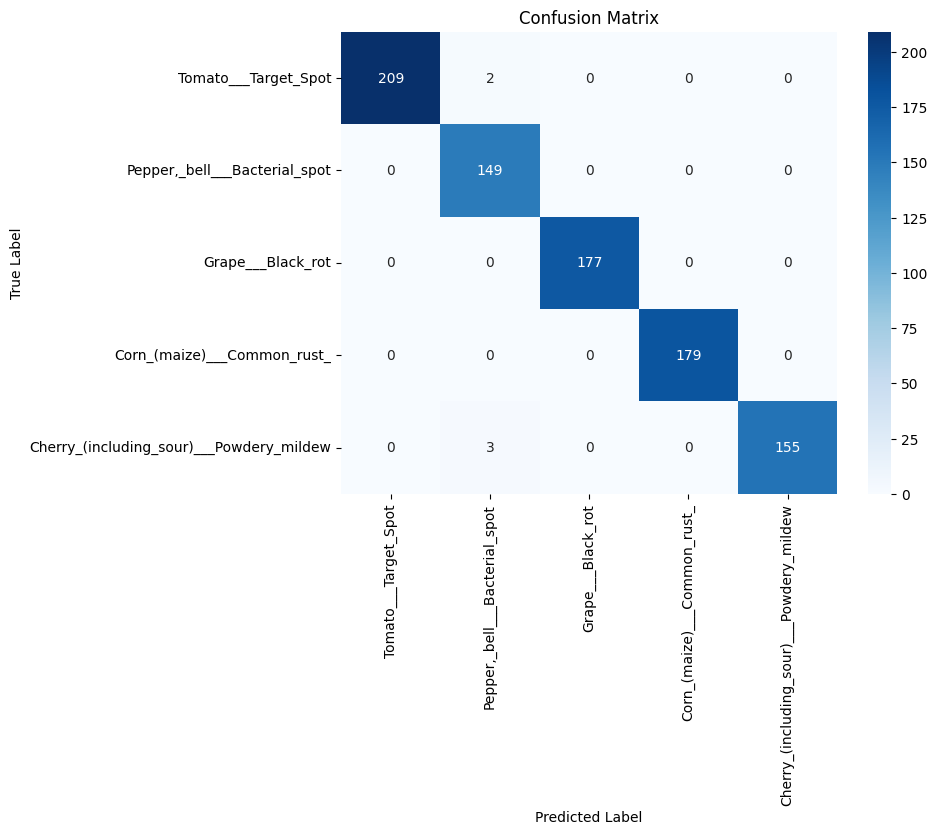

In [51]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification Report
print("Classification Report:\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=selected_classes,
    digits=4
))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=selected_classes,
    yticklabels=selected_classes
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [56]:
def make_gradcam_heatmap(img_array, model, pred_index=None):
    import tensorflow as tf
    import numpy as np

    base_model = model.get_layer("efficientnetb3")

    last_conv_layer = base_model.get_layer("top_conv")

    grad_model = tf.keras.models.Model(
        inputs=base_model.input,
        outputs=last_conv_layer.output
    )

    with tf.GradientTape() as tape:
        conv_outputs = grad_model(img_array)
        tape.watch(conv_outputs)

        x = conv_outputs
        for layer in model.layers[2:]:
            x = layer(x)

        if pred_index is None:
            pred_index = tf.argmax(x[0])

        class_channel = x[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)

    return heatmap.numpy()

Image path : /content/drive/MyDrive/Plantvillage_Dataset/color/Corn_(maize)___Common_rust_/RS_Rust 2411.JPG
True label : Corn_(maize)___Common_rust_
Predicted : Corn_(maize)___Common_rust_
Confidence: 100.0 %


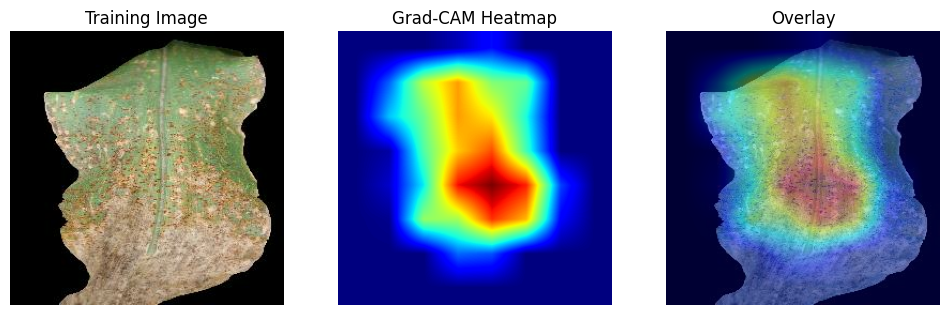

In [59]:
# GRAD-CAM
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

idx = random.randint(0, len(X_train) - 1)
img_path = X_train[idx]
true_label = y_train[idx]

print("Image path :", img_path)
print("True label :", selected_classes[true_label])

img = tf.io.read_file(img_path)
img = tf.image.decode_image(img, channels=3, expand_animations=False)
img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))

img_display = img.numpy().astype("uint8")

img_model = tf.cast(img, tf.float32)
img_model = tf.keras.applications.efficientnet.preprocess_input(img_model)
img_model = tf.expand_dims(img_model, axis=0)

preds = model.predict(img_model, verbose=0)
pred_class = np.argmax(preds[0])
confidence = np.max(preds[0])

print("Predicted :", selected_classes[pred_class])
print("Confidence:", round(confidence * 100, 2), "%")


heatmap = make_gradcam_heatmap(img_model, model)


heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(img_display, 0.6, heatmap_color, 0.4, 0)


plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img_display)
plt.title("Training Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(heatmap, cmap="jet")
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title("Overlay")
plt.axis("off")

plt.show()


In [60]:
# TensorFlow Lite (FP32 , Dynamic INT8)
import tensorflow as tf
from google.colab import drive
import os

KERAS_MODEL_PATH = "/content/drive/MyDrive/Plantvillage_Dataset/best_finetuned_model.keras"

FP32_TFLITE_PATH = "/content/drive/MyDrive/Plantvillage_Dataset/efficientnetb3_finetuned_fp32.tflite"
INT8_TFLITE_PATH = "/content/drive/MyDrive/Plantvillage_Dataset/efficientnetb3_finetuned_dynamic_int8.tflite"

print("Loading fine-tuned EfficientNetB3 model...")

model = tf.keras.models.load_model(
    KERAS_MODEL_PATH,
    custom_objects={"loss": focal_loss}
)

model.summary()

#FP32
print("\nConverting to FP32 TFLite...")
converter_fp32 = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_fp32 = converter_fp32.convert()

with open(FP32_TFLITE_PATH, "wb") as f:
    f.write(tflite_fp32)

print(f"FP32 TFLite model saved at:\n{FP32_TFLITE_PATH}")


#Dynamic INT8
print("\nConverting to Dynamic INT8 TFLite...")

converter_int8 = tf.lite.TFLiteConverter.from_keras_model(model)
converter_int8.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_int8 = converter_int8.convert()

with open(INT8_TFLITE_PATH, "wb") as f:
    f.write(tflite_int8)

print(f" Dynamic INT8 TFLite model saved at:\n{INT8_TFLITE_PATH}")

# Verify both TFLite models
def verify_tflite(model_path):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    return interpreter.get_input_details(), interpreter.get_output_details()

print("\nVerifying FP32 TFLite model...")
fp32_in, fp32_out = verify_tflite(FP32_TFLITE_PATH)
print("FP32 Input :", fp32_in)
print("FP32 Output:", fp32_out)

print("\nVerifying Dynamic INT8 TFLite model...")
int8_in, int8_out = verify_tflite(INT8_TFLITE_PATH)
print("INT8 Input :", int8_in)
print("INT8 Output:", int8_out)

Loading fine-tuned EfficientNetB3 model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 8, 8, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,980,096 (45.70 MB)

 Trainable params: 397,829 (1.52 MB)

 Non-trainable params: 10,786,607 (41.15 MB)

 Optimizer params: 795,660 (3.04 MB)


Converting to FP32 TFLite...
Saved artifact at '/tmp/tmpzbzwltvu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  135915569111184: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  135915569114448: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  135915580875088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135915580882192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135915580876624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135915580878928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135915580881808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135915580878544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135915580874512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135915580879312: TensorSpec(shape=(

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


FP32 Input : [{'name': 'serving_default_input_layer_2:0', 'index': 0, 'shape': array([  1, 256, 256,   3], dtype=int32), 'shape_signature': array([ -1, 256, 256,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
FP32 Output: [{'name': 'StatefulPartitionedCall_1:0', 'index': 776, 'shape': array([1, 5], dtype=int32), 'shape_signature': array([-1,  5], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]

Verifying Dynamic INT8 TFLite model...
INT8 Input : [{'name': 'serving_default_input_layer_2:0', 'index': 0, 'shape': array([  1, 256, 256,   3], dtype=int32), 'shape_signature': array([ -1, 256, 256,   3], dtype=int32), 'dtype

In [61]:
import os

def get_size_mb(path):
    return os.path.getsize(path) / (1024 * 1024)


keras_size = get_size_mb(KERAS_MODEL_PATH)


fp32_size = get_size_mb(FP32_TFLITE_PATH)
int8_size = get_size_mb(INT8_TFLITE_PATH)

print("\n MODEL SIZE COMPARISON")
print("-" * 40)
print(f"Keras model (.keras)        : {keras_size:.2f} MB")
print(f"TFLite FP32                : {fp32_size:.2f} MB")
print(f"TFLite Dynamic INT8        : {int8_size:.2f} MB")

print("\n Size Reduction")
print("-" * 40)
print(f"FP32 reduction vs Keras    : {((keras_size - fp32_size) / keras_size) * 100:.2f}%")
print(f"INT8 reduction vs Keras    : {((keras_size - int8_size) / keras_size) * 100:.2f}%")


 MODEL SIZE COMPARISON
----------------------------------------
Keras model (.keras)        : 46.98 MB
TFLite FP32                : 42.28 MB
TFLite Dynamic INT8        : 11.60 MB

 Size Reduction
----------------------------------------
FP32 reduction vs Keras    : 10.02%
INT8 reduction vs Keras    : 75.31%


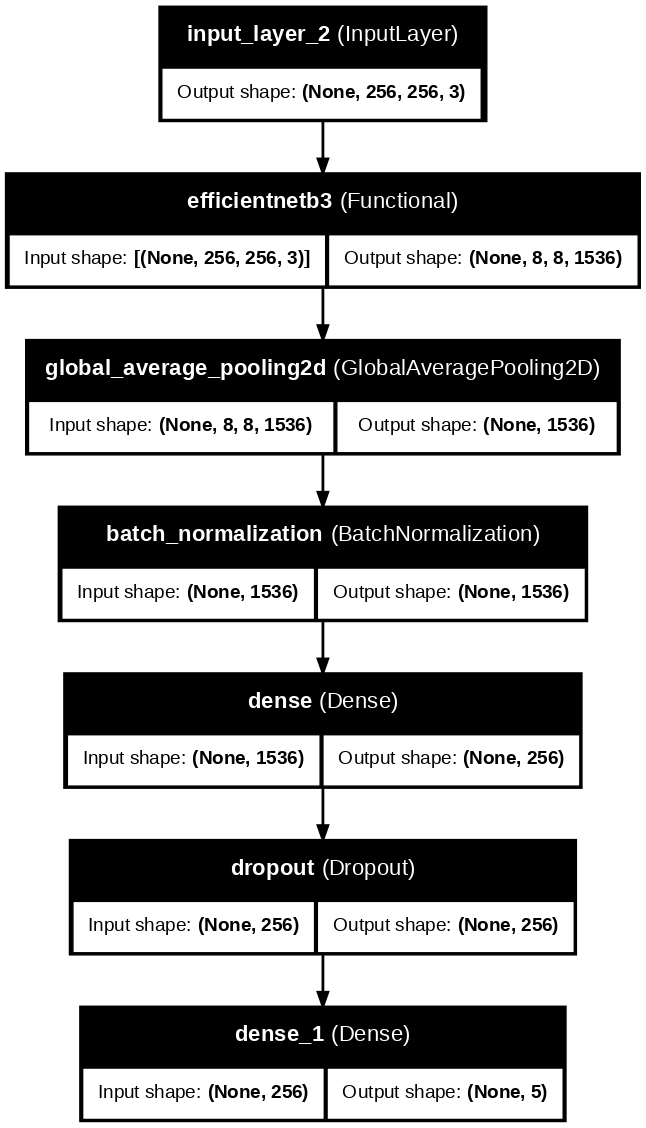

In [66]:
from tensorflow.keras.utils import plot_model

plot_model(
    model,
    to_file="efficientnetb3_model.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=False,
    dpi=100
)

